In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
import copy
import sys
import os
from pylab import *
import copy

In [2]:
def field_field_coherence(x,y,dt, trl_indx = None):

    if trl_indx is not None:
        x = x[trl_indx,:]
        y = y[trl_indx,:]
#    print(x.shape)
        
    T = x.shape[0]    
    N = x.shape[1] 
    
    #generating arrays
    SYY = np.zeros(int(N/2+1))                            
    SXX = np.zeros(int(N/2+1))                        
    SYX = np.zeros(int(N/2+1), dtype=complex)           

    #loop over trials
    for k in range(T):                                

        yf = rfft((y[k,:]-np.mean(y[k,:])) *hanning(N))   #rfft of y 
        nf = rfft((x[k,:]-np.mean(x[k,:])) *hanning(N))   #rfft of x
        SYY = SYY + ( real( yf*conj(yf) ) )/T       #this appends power spectra (for y) for this trial
        SXX = SXX + ( real( nf*conj(nf) ) )/T           # ""  for x
        SYX = SYX + ( yf*conj(nf)   )/T     # "" xy

    coh = abs(SYX) / np.sqrt(SYY) / np.sqrt(SXX)            
    f = rfftfreq(N, dt)
    
    return coh, f   

def preprocess(data):
    zeros = np.zeros_like(data)
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
   
    std[std == 0] = 1  # Avoid division by zero by setting std to 1 where it is 0
    zeros = (data - mean) / std
    return zeros



In [40]:
run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)

agg_structure = {cl: 
                  {cr: [] for cr in classes_right} for cl in classes_left} 


l_al_data = copy.deepcopy(agg_structure)
r_al_data = copy.deepcopy(agg_structure)
a_al_data = copy.deepcopy(agg_structure)

l_ar_data = copy.deepcopy(agg_structure)
r_ar_data = copy.deepcopy(agg_structure)
a_ar_data = copy.deepcopy(agg_structure)


n_values = {cl:
             {cr: {
                'attleft': [],
                'attright': []
                } for cr in classes_right} for cl in classes_left} 

#loading the data by class combinations

for file_number in file_numbers:   #will first load the file and extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]    #indices of agg where not omitted

    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])

    for cl in classes_left:
        for cr in classes_right: 
    
            left_indices_agg = np.where((omitted ==0) & (attend_01 == 0) & (label_left == cl) & (label_right == cr))[0]
            left_indices = np.where(np.isin(relevant, left_indices_agg))[0]
            right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left == cl) & (label_right == cr))[0]
            right_indices = np.where(np.isin(relevant, right_indices_agg))[0]
       
            n_values[cl][cr][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[cl][cr][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty

            if len(left_indices) >= 1:
                l_al = left_input_LFP[left_indices][:, 100:350]
                r_al = right_input_LFP[left_indices][:, 100:350]
                a_al = attention_LFP[left_indices][:, 100:350]

                l_al_data[cl][cr].append(l_al)
                r_al_data[cl][cr].append(r_al)
                a_al_data[cl][cr].append(a_al)

            if len(right_indices) >= 1:

                l_ar = left_input_LFP[right_indices][:, 100:350]
                r_ar = right_input_LFP[right_indices][:, 100:350]
                a_ar = attention_LFP[right_indices][:, 100:350]

                l_ar_data[cl][cr].append(l_ar)   
                r_ar_data[cl][cr].append(r_ar)
                a_ar_data[cl][cr].append(a_ar)

            if cl == 1 and cr == 1:
                print('found a 11')
                print(left_indices)

          

    del data
    gc.collect()



found a 11
[431 548]
found a 11
[251]
found a 11
[]
found a 11
[490]
found a 11
[]
found a 11
[ 37 525 598]
found a 11
[248]
found a 11
[146 695 860 981]


In [41]:
for cl in classes_left:
    for cr in classes_right:
        if len(l_al_data[cl][cr]) > 0:
            l_al_data[cl][cr] = np.concatenate(l_al_data[cl][cr], axis = 0)
            r_al_data[cl][cr] = np.concatenate(r_al_data[cl][cr], axis = 0)
            a_al_data[cl][cr] = np.concatenate(a_al_data[cl][cr], axis = 0)

            l_ar_data[cl][cr] = np.concatenate(l_ar_data[cl][cr], axis = 0)
            r_ar_data[cl][cr] = np.concatenate(r_ar_data[cl][cr], axis = 0)
            a_ar_data[cl][cr] = np.concatenate(a_ar_data[cl][cr], axis = 0)
            

        else:
            print(f"No data for class left {cl} and class right {cr}.")


##-----------------calculating the number of trials for each class pair----------------
n_values_sum = {cl: {cr: {'attleft': 0, 'attright': 0} for cr in classes_right} for cl in classes_left}


for cl in classes_left:
    for cr in classes_right:
        n_values_sum[cl][cr]['attleft'] = len(l_al_data[cl][cr]) 
        n_values_sum[cl][cr]['attright'] = len(l_ar_data[cl][cr]) 
        

In [44]:
#-------------coherence calculation----------------
dt = 0.002
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']   #for coherence I have looked at the mean valuee for these bands
freq_ranges = [(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 80)]  # Actual frequency ranges


lr_split_structure = {cl: {cr: {band:  {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for band in bands} for cr in classes_right} for cl in classes_left} 


coh_means = copy.deepcopy(lr_split_structure)
coh_stdevs = copy.deepcopy(lr_split_structure)

run_time = time.time()
for cl in classes_left:
    coh_start = time.time()
    for cr in classes_right: 

        if n_values_sum[cl][cr]['attleft'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            continue                    
        
        #for attention left condition:
        left_in_coh_leftatt, freq = field_field_coherence(
            l_al_data[cl][cr],
            a_al_data[cl][cr],
            dt
        )
        right_in_coh_leftatt, freq = field_field_coherence(
            r_al_data[cl][cr],
            a_al_data[cl][cr],
            dt
        )
        
        #-----taking the mean value of coh for each band  | left condition
        for band, (f_min, f_max) in zip(bands, freq_ranges):
            band_idx = (freq >= f_min) & (freq < f_max)
            coh_means[cl][cr][band]['left_attleft'].append(
                np.mean(left_in_coh_leftatt[band_idx]))  #taking the mean across trials
            coh_means[cl][cr][band]['right_attleft'].append(
                np.mean(right_in_coh_leftatt[band_idx]))

            coh_stdevs[cl][cr][band]['left_attleft'].append(
                np.std(left_in_coh_leftatt[band_idx], ddof=1))
            coh_stdevs[cl][cr][band]['right_attleft'].append(
                np.std(right_in_coh_leftatt[band_idx], ddof=1))
            


for cl in classes_left:
    for cr in classes_right: 
        if n_values_sum[cl][cr]['attright'] == 0:  #right class pairs that have trials
            print(f"[SKIP] {cl}-{cr}: no attleft trials")
            continue        

        #for attention right condition:
        left_in_coh_rightatt, freq = field_field_coherence(
            l_ar_data[cl][cr],
            a_ar_data[cl][cr],
            dt
        )
        right_in_coh_rightatt, freq = field_field_coherence(
            r_ar_data[cl][cr],
            a_ar_data[cl][cr],
            dt
        )   

        if left_in_coh_leftatt.size == 0 or right_in_coh_leftatt.size == 0:
            print(f"[WARN] empty coherence array for {cl}-{cr} under attleft")


        #taking the mean value of coh for each band  | right condition
        for band, (f_min, f_max) in zip(bands, freq_ranges):
            band_idx = (freq >= f_min) & (freq < f_max)
            coh_means[cl][cr][band]['left_attright'].append(
                np.mean(left_in_coh_rightatt[band_idx]))  #taking the mean across trials
            coh_means[cl][cr][band]['right_attright'].append(
                np.mean(right_in_coh_rightatt[band_idx]))

            coh_stdevs[cl][cr][band]['left_attright'].append(
                np.std(left_in_coh_rightatt[band_idx], ddof=1))
            coh_stdevs[cl][cr][band]['right_attright'].append(
                np.std(right_in_coh_rightatt[band_idx], ddof=1))




    print(f"Class pair {cl} {cr} processed in {time.time() - coh_start:.2f} seconds")
         
run_time = time.time() - run_time
print(f"Total run time: {run_time:.2f} seconds")


c:\Users\joshu\nice\.venv\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\joshu\nice\.venv\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Class pair 0 19 processed in 0.07 seconds
Class pair 1 19 processed in 0.11 seconds
Class pair 2 19 processed in 0.15 seconds
Class pair 3 19 processed in 0.18 seconds
Class pair 4 19 processed in 0.22 seconds
Class pair 5 19 processed in 0.26 seconds
Class pair 6 19 processed in 0.29 seconds
Class pair 7 19 processed in 0.34 seconds
Class pair 8 19 processed in 0.38 seconds
Class pair 9 19 processed in 0.41 seconds
Class pair 10 19 processed in 0.45 seconds
Class pair 11 19 processed in 0.49 seconds
Class pair 12 19 processed in 0.53 seconds
Class pair 13 19 processed in 0.58 seconds
Class pair 14 19 processed in 0.63 seconds
Class pair 15 19 processed in 0.66 seconds
Class pair 16 19 processed in 0.70 seconds
Class pair 17 19 processed in 0.74 seconds
Class pair 18 19 processed in 0.78 seconds
Class pair 19 19 processed in 0.84 seconds
Total run time: 1.73 seconds


In [47]:
#looking for 0's in the data
for cl in classes_left:
    for cr in classes_right:
        for band in bands:
            for att in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                if len(coh_means[cl][cr][band][att]) == 0:
                    print(f"Empty data for {cl}-{cr} under {band} and {att}")
            

In [ ]:
#--------plotting the results-------------
results_to_plot =copy.deepcopy(lr_split_structure) 

for band in bands:
    for cl in classes_left:
        for cr in classes_right:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot[cl][cr][band][key] = coh_means[cl][cr][band][key]


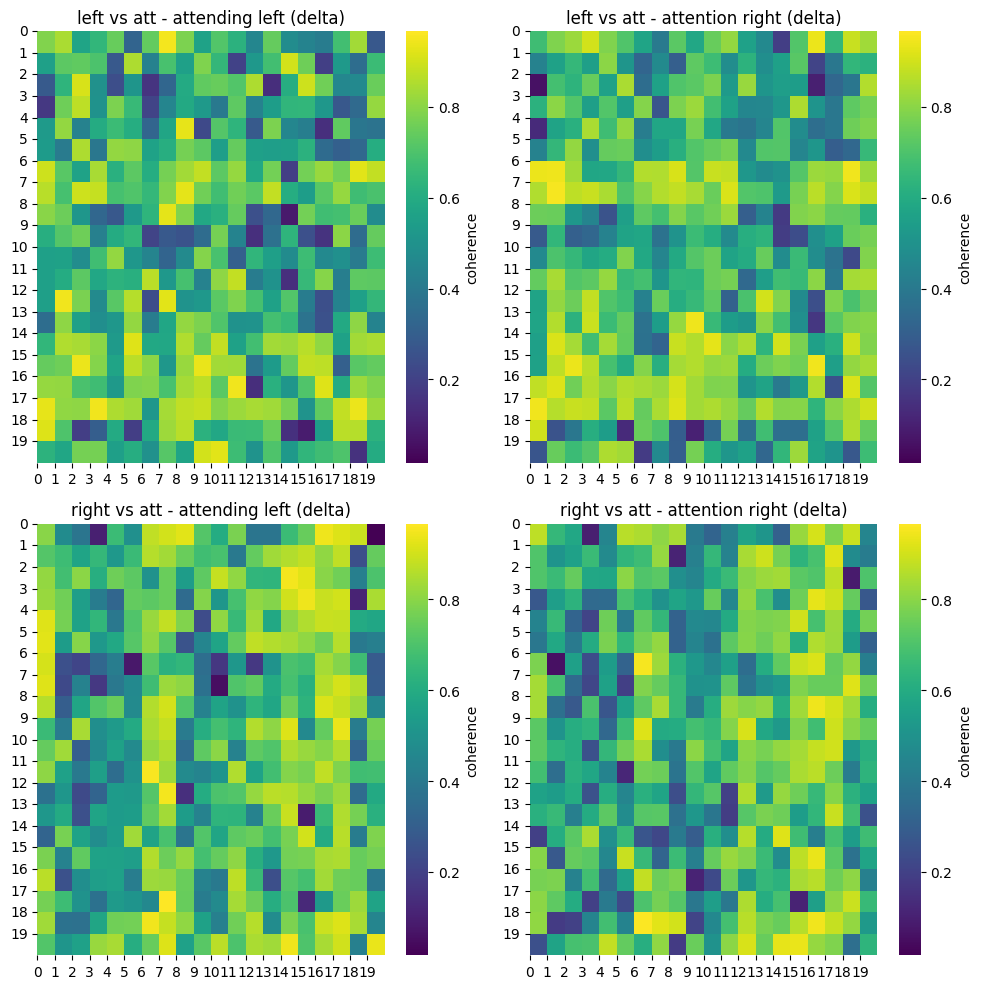

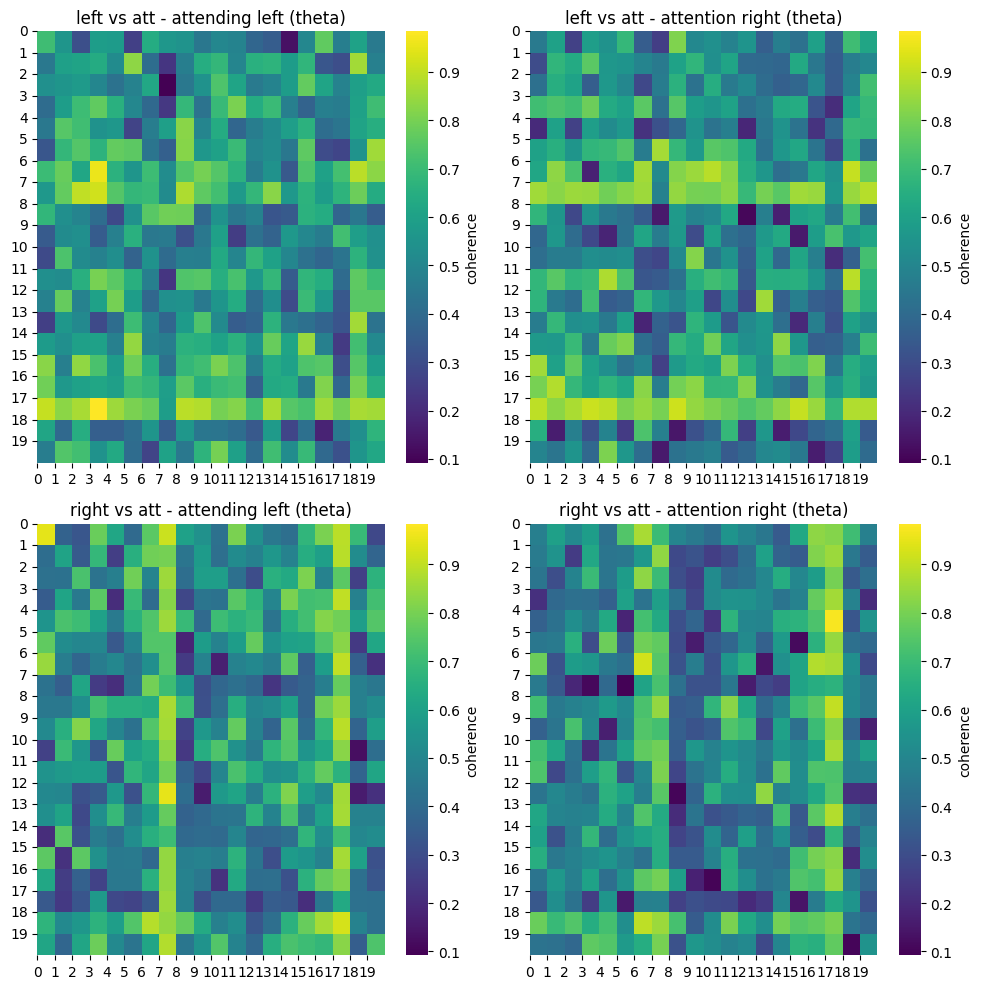

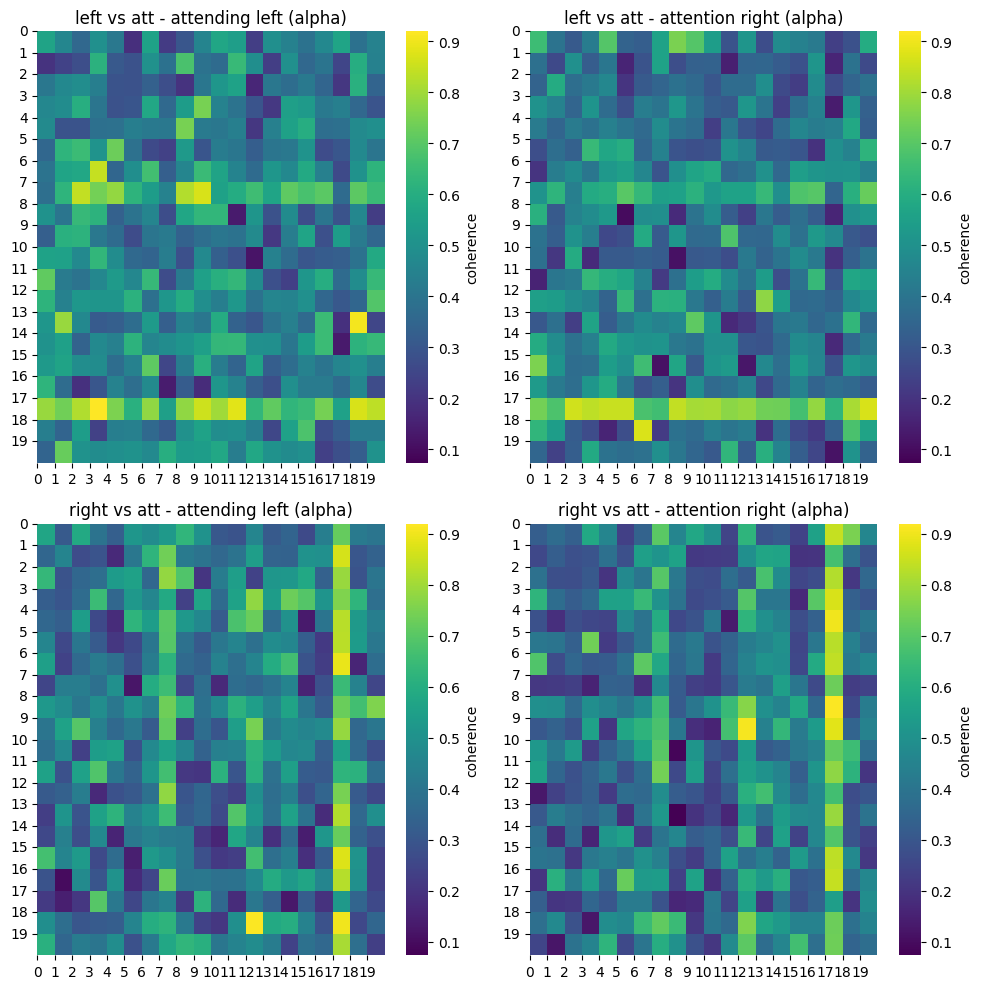

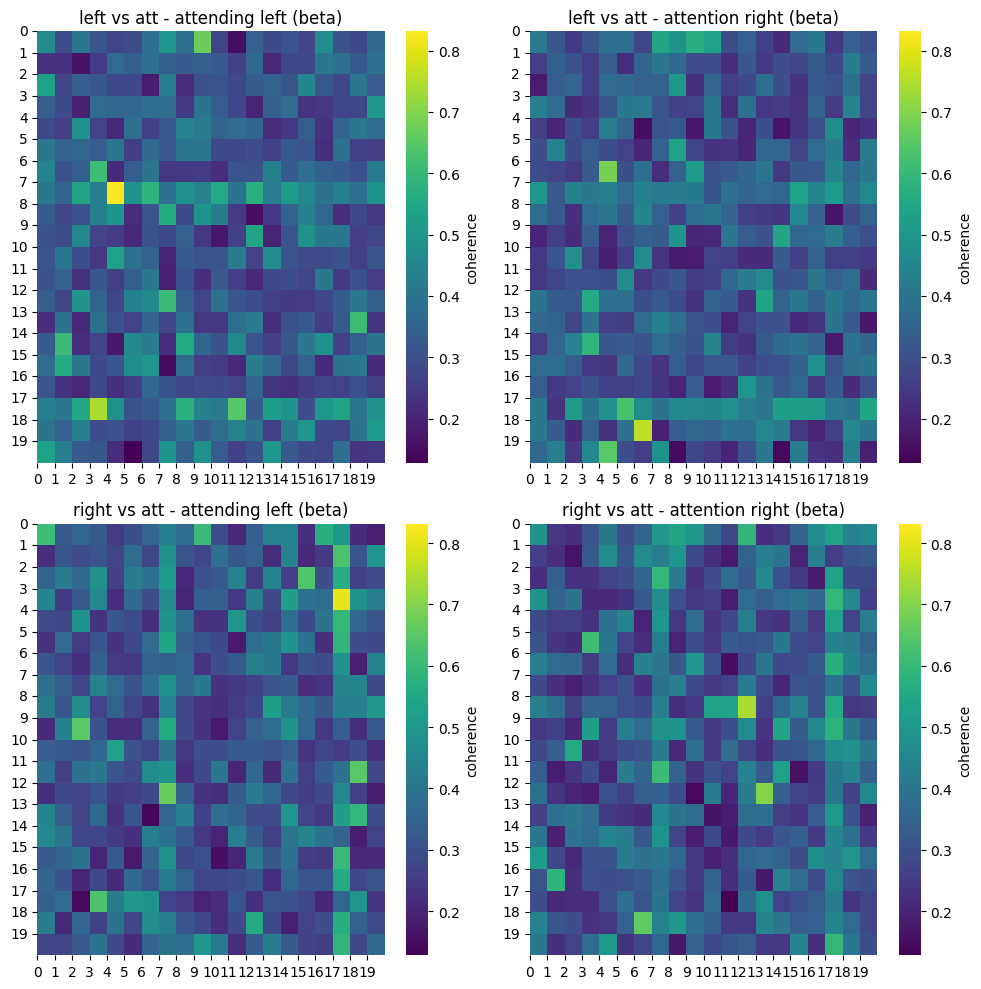

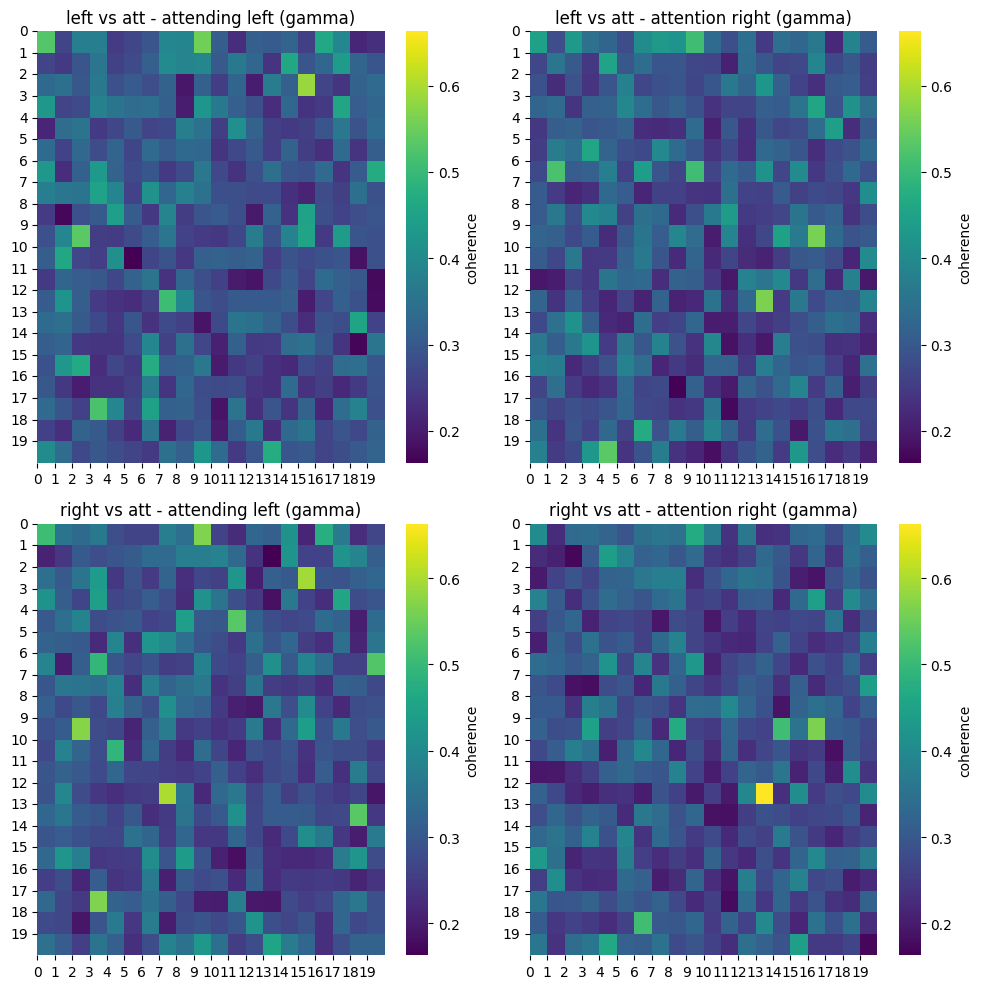

In [73]:
def calculate_vmin_vmax_scalar(data, classes_left, classes_right, band):
    vals = []
    for cl in classes_left:
        for cr in classes_right:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                lst = data[cl][cr][band][key]
                if lst:                   # skip empty lists
                    vals.append(lst[0])    # or take np.mean(lst) if you prefer
    if not vals:
        raise ValueError(f"No non-empty entries for band {band}")
    return min(vals), max(vals)

# recompute your vmin/vmax correctly:
vmin_delta, vmax_delta = calculate_vmin_vmax_scalar(results_to_plot, classes_left, classes_right, 'delta')
vmin_theta, vmax_theta = calculate_vmin_vmax_scalar(results_to_plot, classes_left, classes_right, 'theta')
vmin_alpha, vmax_alpha = calculate_vmin_vmax_scalar(results_to_plot, classes_left, classes_right, 'alpha')
vmin_beta, vmax_beta = calculate_vmin_vmax_scalar(results_to_plot, classes_left, classes_right, 'beta')
vmin_gamma, vmax_gamma = calculate_vmin_vmax_scalar(results_to_plot, classes_left, classes_right, 'gamma')
# … same for the others …

def plot_4_heat(data, band, vmin, vmax):
    nL, nR = len(classes_left), len(classes_right)
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    def mkmat(key):
        mat = np.full((nL, nR), np.nan)
        for i, cl in enumerate(classes_left):
            for j, cr in enumerate(classes_right):
                lst = data[cl][cr][band][key]
                if lst:
                    mat[i,j] = lst[0]
        return mat

    sns.heatmap(mkmat('left_attleft'), ax=ax[0,0], vmin=vmin, vmax=vmax,
                cmap='viridis', cbar_kws={'label':'coherence'})
    ax[0,0].set_title(f'left vs att ‑ attending left ({band})')
    ax[0,0].set_xticks(np.arange(nR)); ax[0,0].set_yticks(np.arange(nL))
    ax[0,0].set_xticklabels(classes_right); ax[0,0].set_yticklabels(classes_left)

    sns.heatmap(mkmat('right_attleft'), ax=ax[1,0], vmin=vmin, vmax=vmax,
                cmap='viridis', cbar_kws={'label':'coherence'})
    ax[1,0].set_title(f'right vs att ‑ attending left ({band})')
    ax[1,0].set_xticks(np.arange(nR)); ax[1,0].set_yticks(np.arange(nL))
    ax[1,0].set_xticklabels(classes_right); ax[1,0].set_yticklabels(classes_left)

    sns.heatmap(mkmat('left_attright'), ax=ax[0,1], vmin=vmin, vmax=vmax,
                cmap='viridis', cbar_kws={'label':'coherence'})
    ax[0,1].set_title(f'left vs att ‑ attention right ({band})')
    ax[0,1].set_xticks(np.arange(nR)); ax[0,1].set_yticks(np.arange(nL))
    ax[0,1].set_xticklabels(classes_right); ax[0,1].set_yticklabels(classes_left)

    sns.heatmap(mkmat('right_attright'), ax=ax[1,1], vmin=vmin, vmax=vmax,
                cmap='viridis', cbar_kws={'label':'coherence'})
    ax[1,1].set_title(f'right vs att ‑ attention right ({band})')
    ax[1,1].set_xticks(np.arange(nR)); ax[1,1].set_yticks(np.arange(nL))
    ax[1,1].set_xticklabels(classes_right); ax[1,1].set_yticklabels(classes_left)

    plt.tight_layout()
    plt.show()


plot_4_heat(results_to_plot, 'delta', vmin_delta, vmax_delta)
plot_4_heat(results_to_plot, 'theta', vmin_theta, vmax_theta)
plot_4_heat(results_to_plot, 'alpha', vmin_alpha, vmax_alpha)
plot_4_heat(results_to_plot, 'beta', vmin_beta, vmax_beta)
plot_4_heat(results_to_plot, 'gamma', vmin_gamma, vmax_gamma)

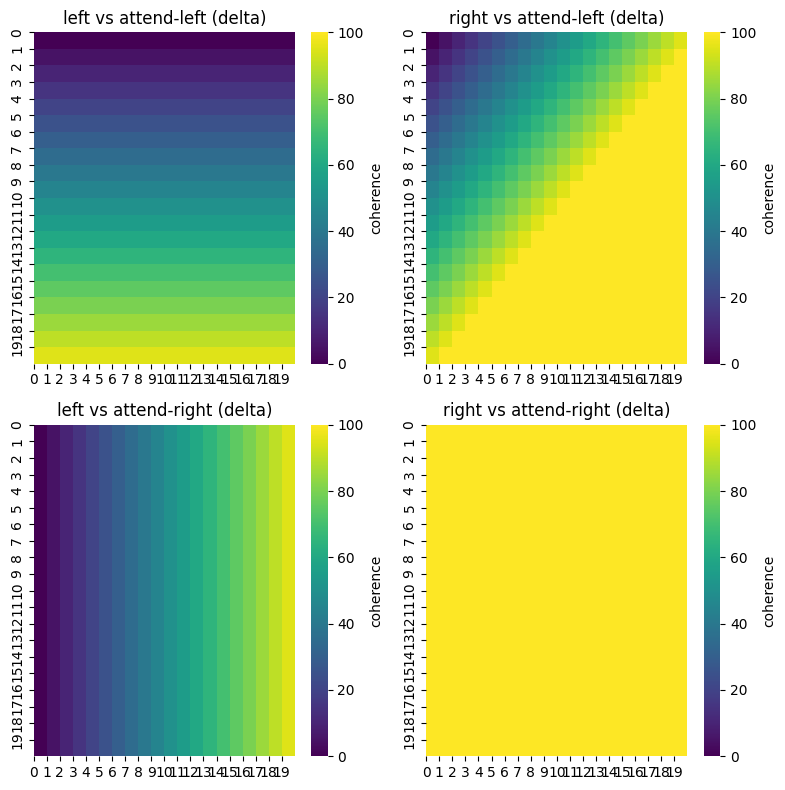

In [70]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Coerce to plain Python ints
classes_left  = [int(x) for x in classes_left]
classes_right = [int(x) for x in classes_right]

# 2) Now build the toy dict (all keys are Python ints)
toy = {
    cl: {
        cr: {
            'delta': {
                'left_attleft':   [5*cl],
                'left_attright':  [5*cr],
                'right_attleft':  [5*(cl+cr)],
                'right_attright': [100],
            }
        } for cr in classes_right
    } for cl in classes_left
}

# 3) Your plot function can stay exactly the same:
def plot_4_heat(data, band, vmin, vmax):
    nL, nR = len(classes_left), len(classes_right)
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    def mkmat(key):
        mat = np.full((nL, nR), np.nan)
        for i, cl in enumerate(classes_left):
            for j, cr in enumerate(classes_right):
                lst = data[cl][cr][band][key]  # cl,cr are now plain ints
                if lst:
                    mat[i, j] = lst[0]
        return mat

    keys   = ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']
    titles = [
        f'left vs attend-left ({band})',
        f'right vs attend-left ({band})',
        f'left vs attend-right ({band})',
        f'right vs attend-right ({band})',
    ]

    for ax, key, title in zip(axes.flatten(), keys, titles):
        sns.heatmap(mkmat(key), ax=ax,
                    vmin=vmin, vmax=vmax,
                    cmap='viridis',
                    cbar_kws={'label':'coherence'})
        ax.set_title(title)
        ax.set_xticks(np.arange(nR))
        ax.set_yticks(np.arange(nL))
        ax.set_xticklabels(classes_right)
        ax.set_yticklabels(classes_left)

    plt.tight_layout()
    plt.show()

# 4) Finally call it
plot_4_heat(toy, 'delta', vmin=0, vmax=100)


In [49]:
for cl in classes_left:
    for cr in classes_right:
        for band in bands:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot[cl][cr][band][key] = coh_means[cl][cr][band][key]


lowest_classes = lowest_classes = [(np.int64(12), np.int64(18)), (np.int64(18), np.int64(12)), (np.int64(7), np.int64(18)), (np.int64(14), np.int64(18)), (np.int64(18), np.int64(7)), (np.int64(12), np.int64(8)), (np.int64(8), np.int64(12)), (np.int64(7), np.int64(8)), (np.int64(8), np.int64(7)), (np.int64(18), np.int64(15)), (np.int64(16), np.int64(12)), (np.int64(18), np.int64(14)), (np.int64(6), np.int64(18)), (np.int64(15), np.int64(18)), (np.int64(8), np.int64(14)), (np.int64(11), np.int64(7)), (np.int64(17), np.int64(18)), (np.int64(7), np.int64(11)), (np.int64(16), np.int64(7)), (np.int64(3), np.int64(12)), (np.int64(11), np.int64(12)), (np.int64(18), np.int64(17)), (np.int64(18), np.int64(6)), (np.int64(12), np.int64(10)), (np.int64(12), np.int64(11)), (np.int64(0), np.int64(18)), (np.int64(18), np.int64(2)), (np.int64(7), np.int64(10)), (np.int64(7), np.int64(16)), (np.int64(2), np.int64(18)), (np.int64(18), np.int64(0)), (np.int64(12), np.int64(6)), (np.int64(7), np.int64(1)), (np.int64(6), np.int64(8)), (np.int64(12), np.int64(16)), (np.int64(12), np.int64(1)), (np.int64(7), np.int64(19)), (np.int64(17), np.int64(8)), (np.int64(10), np.int64(7)), (np.int64(18), np.int64(13)), (np.int64(6), np.int64(12)), (np.int64(12), np.int64(19)), (np.int64(19), np.int64(12)), (np.int64(12), np.int64(5)), (np.int64(9), np.int64(12)), (np.int64(4), np.int64(18)), (np.int64(10), np.int64(12)), (np.int64(18), np.int64(4)), (np.int64(6), np.int64(17)), (np.int64(8), np.int64(17)), (np.int64(16), np.int64(17)), (np.int64(16), np.int64(15)), (np.int64(8), np.int64(6)), (np.int64(7), np.int64(9)), (np.int64(7), np.int64(5)), (np.int64(17), np.int64(6)), (np.int64(17), np.int64(16)), (np.int64(11), np.int64(14)), (np.int64(18), np.int64(5)), (np.int64(7), np.int64(6)), (np.int64(6), np.int64(10)), (np.int64(13), np.int64(18)), (np.int64(14), np.int64(8)), (np.int64(18), np.int64(3)), (np.int64(8), np.int64(0)), (np.int64(6), np.int64(5)), (np.int64(1), np.int64(7)), (np.int64(15), np.int64(8)), (np.int64(16), np.int64(14)), (np.int64(0), np.int64(8)), (np.int64(8), np.int64(2)), (np.int64(1), np.int64(12)), (np.int64(12), np.int64(3)), (np.int64(16), np.int64(0)), (np.int64(19), np.int64(7)), (np.int64(19), np.int64(6)), (np.int64(5), np.int64(7)), (np.int64(3), np.int64(7)), (np.int64(19), np.int64(17)), (np.int64(9), np.int64(7))]

results_to_plot_low = copy.deepcopy(lr_split_structure)


for cl in classes_left:
    for cr in classes_right:
        if (cl, cr) in lowest_classes:
            for band in bands:
                for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                    results_to_plot_low[cl][cr][band][key] = coh_means[cl][cr][band][key]
        else:   #if not in lowest classes, set to -
            for band in bands:
                for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                    results_to_plot_low[cl][cr][band][key] = -1

print(np.array(results_to_plot))
print(np.array(results_to_plot_low))
                


{np.int64(0): {np.int64(0): {'delta': {'left_attleft': [np.float64(0.7859647283482197)], 'right_attleft': [np.float64(0.7977913920441501)], 'left_attright': [np.float64(0.6711691692856934)], 'right_attright': [np.float64(0.8708592939766069)]}, 'theta': {'left_attleft': [np.float64(0.7079377923956294)], 'right_attleft': [np.float64(0.9482164326687139)], 'left_attright': [np.float64(0.45626980935791067)], 'right_attright': [np.float64(0.4750671038446379)]}, 'alpha': {'left_attleft': [np.float64(0.5636859157068141)], 'right_attleft': [np.float64(0.5718843543230681)], 'left_attright': [np.float64(0.652725521842264)], 'right_attright': [np.float64(0.3241152644044361)]}, 'beta': {'left_attleft': [np.float64(0.4628280035376716)], 'right_attleft': [np.float64(0.6114154453798163)], 'left_attright': [np.float64(0.4153089406217923)], 'right_attright': [np.float64(0.49053224376553217)]}, 'gamma': {'left_attleft': [np.float64(0.5287229362718433)], 'right_attleft': [np.float64(0.5050774950701742)], 

Below I plot some histograms, the hope would be that the mean coherence would be larger between left/competition layer than right when attending left, and visa versa for attending right. If not, would hope that perhaps the inputs with the least pearson correlation would be displaced in this direction. 

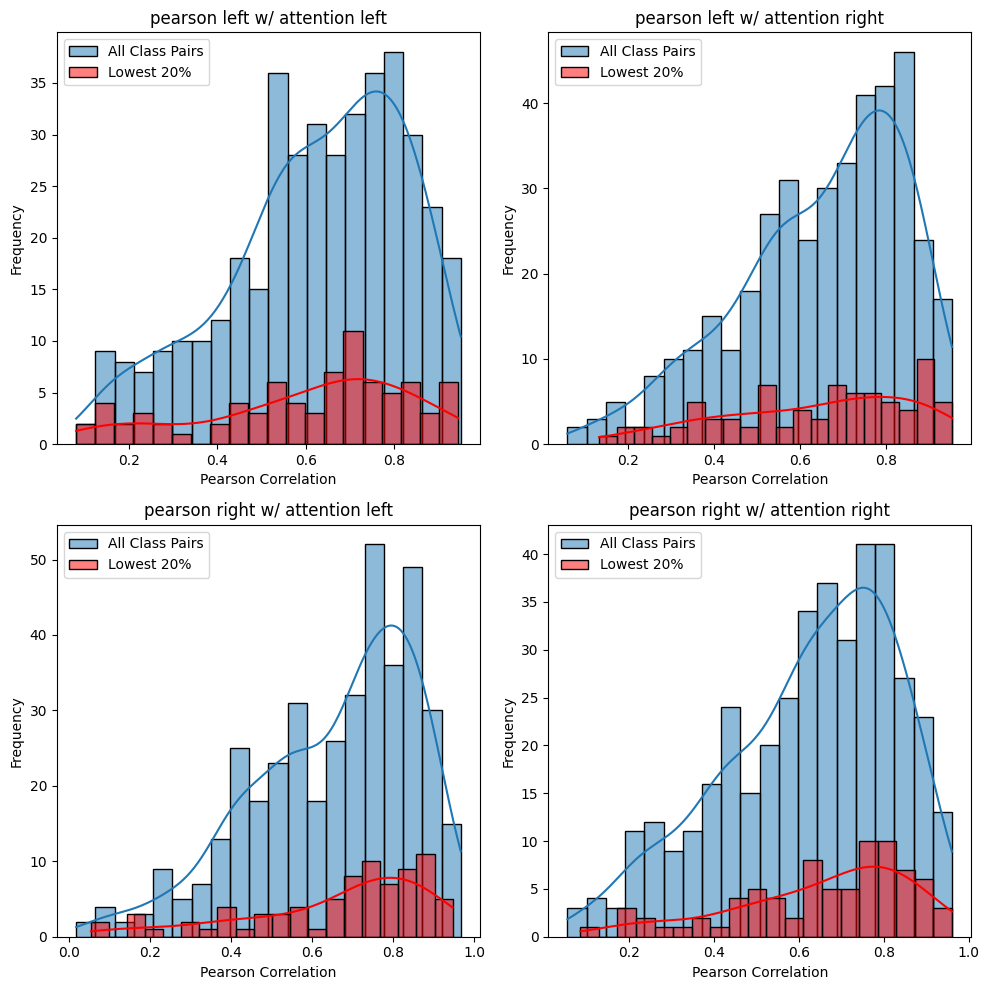

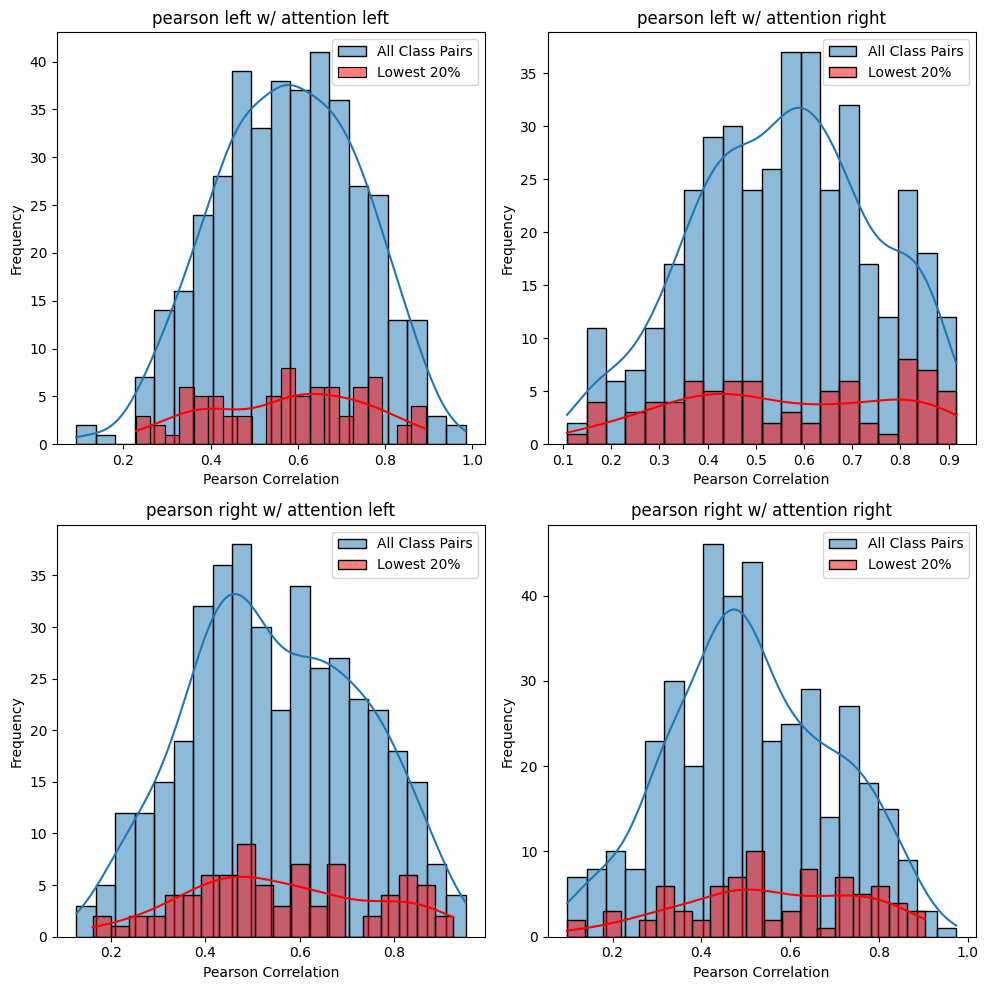

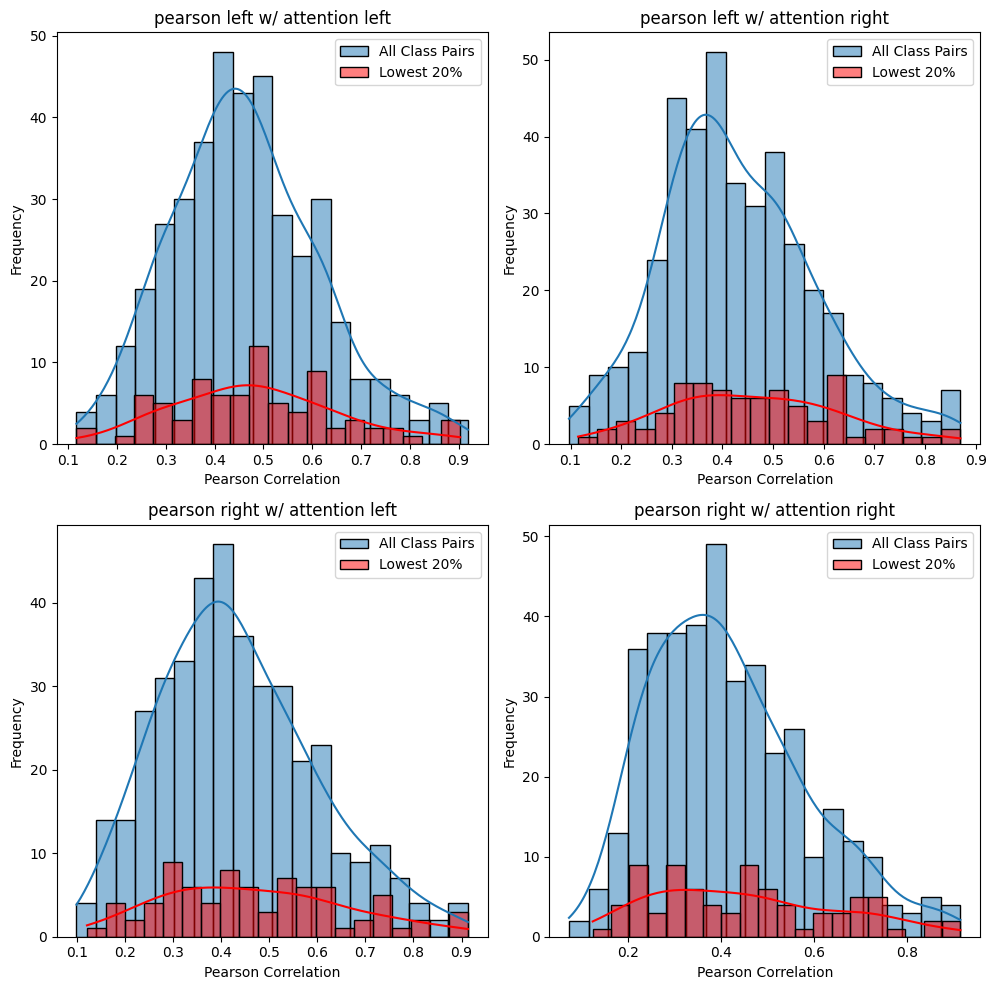

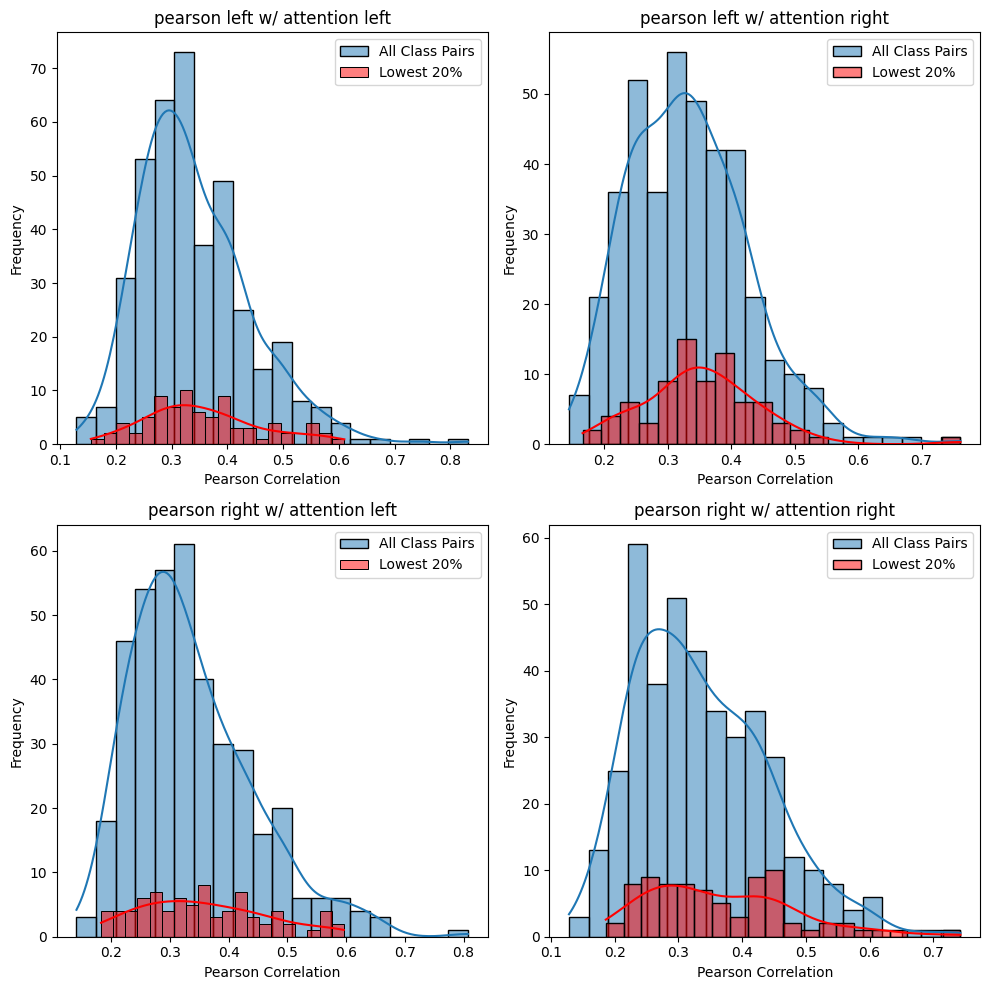

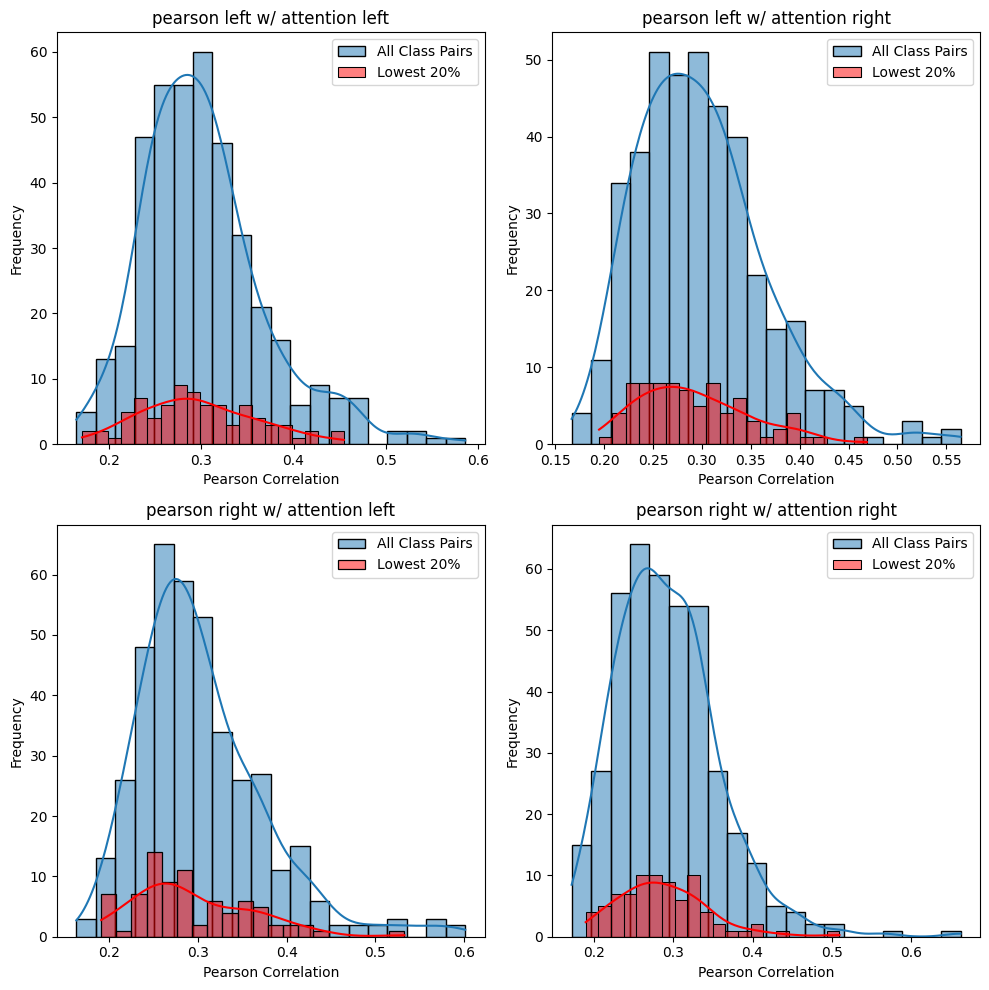

In [51]:
def plot_histograms(data, datalow, band):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    # Flatten the extracted wSMI values into 1D lists before plotting
    hist_values_all = [data[cl][cr][band]['left_attleft']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [datalow[cl][cr][band]['left_attleft']
                        for cl in classes_left for cr in classes_right if datalow[cl][cr][band]['left_attleft'] != -1]
    sns.histplot(np.array(hist_values_all), ax=ax[0, 0], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[0, 0], bins=20, kde=True, label="Lowest 20%", palette = ['red'], alpha=0.5)
    ax[0,0].set_title('pearson left w/ attention left')
    ax[0,0].set_xlabel('Pearson Correlation')
    ax[0,0].set_ylabel('Frequency')
    ax[0,0].legend()

    # Repeat for the other plots
    hist_values_all = [data[cl][cr][band]['right_attleft']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [datalow[cl][cr][band]['right_attleft']
                        for cl in classes_left for cr in classes_right if datalow[cl][cr][band]['right_attleft'] != -1]

    sns.histplot(np.array(hist_values_all), ax=ax[1, 0], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[1, 0], bins=20, kde=True, label="Lowest 20%", palette = ['red'], alpha=0.5)
    ax[1,0].set_title('pearson right w/ attention left')
    ax[1,0].set_xlabel('Pearson Correlation')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].legend()

    hist_values_all = [data[cl][cr][band]['left_attright']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [datalow[cl][cr][band]['left_attright']
                        for cl in classes_left for cr in classes_right if datalow[cl][cr][band]['left_attright'] != -1]

    sns.histplot(np.array(hist_values_all), ax=ax[0, 1], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[0, 1], bins=20, kde=True, label="Lowest 20%", palette = ['red'], alpha=0.5)
    ax[0,1].set_title('pearson left w/ attention right')
    ax[0,1].set_xlabel('Pearson Correlation')
    ax[0,1].set_ylabel('Frequency')
    ax[0,1].legend()

    hist_values_all = [data[cl][cr][band]['right_attright']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [datalow[cl][cr][band]['right_attright']
                        for cl in classes_left for cr in classes_right if datalow[cl][cr][band]['right_attright'] != -1]

    sns.histplot(np.array(hist_values_all), ax=ax[1, 1], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(np.array(hist_values_low), ax=ax[1, 1], bins=20, kde=True, label="Lowest 20%", palette = ['red'], alpha=0.5)
    ax[1,1].set_title('pearson right w/ attention right')
    ax[1,1].set_xlabel('Pearson Correlation')
    ax[1,1].set_ylabel('Frequency')
    ax[1,1].legend()

    plt.tight_layout()
    plt.show()

plot_histograms(results_to_plot, results_to_plot_low, 'delta')
plot_histograms(results_to_plot, results_to_plot_low, 'theta')
plot_histograms(results_to_plot, results_to_plot_low, 'alpha')
plot_histograms(results_to_plot, results_to_plot_low, 'beta')
plot_histograms(results_to_plot, results_to_plot_low, 'gamma')
